Base stats shape: (572, 67)
Advanced stats shape: (572, 79)
Hustle stats shape: (567, 28)
Merged shape: (572, 79)
Using 26 features: ['AST', 'AST_TOV', 'BLK', 'BOX_OUTS', 'CHARGES_DRAWN', 'CONTESTED_SHOTS', 'DEFLECTIONS', 'DEF_RATING', 'DREB', 'FG3A', 'FG3_PCT', 'FGA', 'FG_PCT', 'LOOSE_BALLS_RECOVERED', 'NET_RATING', 'OFF_RATING', 'OREB', 'PTS', 'REB', 'SCREEN_ASSISTS', 'SCREEN_AST_PTS', 'STL', 'THREE_RATE', 'TOV', 'TS_PCT', 'USG_PCT']


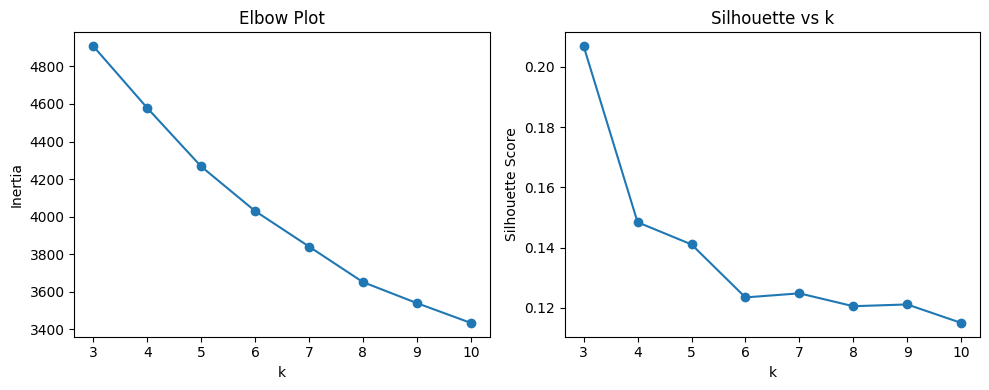

k values: [3, 4, 5, 6, 7, 8, 9, 10]
Inertias: [4907.840245605809, 4578.987356266692, 4267.443438176469, 4030.19847785865, 3840.9662972354754, 3651.719274008083, 3539.8042705536973, 3434.370936600813]
Silhouettes: [0.20688899597454496, 0.14842045399609766, 0.14104616856703725, 0.12344946632447544, 0.12480181154049128, 0.12052914036587727, 0.12111467924013454, 0.11498993694431593]


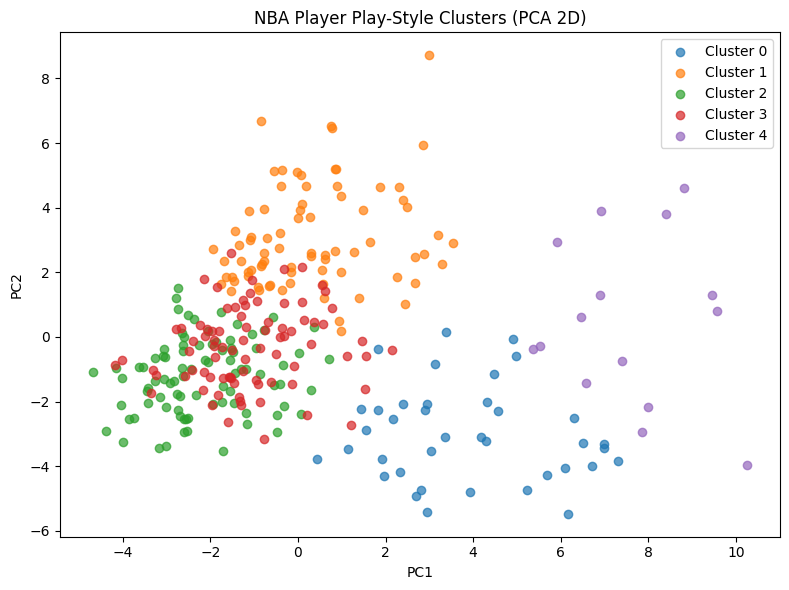

In [32]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nba_api.stats.endpoints import (
    leaguedashplayerstats,
    leaguehustlestatsplayer,
)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

SEASON = "2023-24"
SEASON_TYPE = "Regular Season"


def fetch_base_stats():
    """Per-game traditional box score stats."""
    resp = leaguedashplayerstats.LeagueDashPlayerStats(
        season=SEASON,
        season_type_all_star=SEASON_TYPE,
        per_mode_detailed="PerGame",
        measure_type_detailed_defense="Base"
    )
    df = resp.get_data_frames()[0]
    return df


def fetch_advanced_stats():
    """Per-game advanced stats (TS%, USG%, ratings if available)."""
    resp = leaguedashplayerstats.LeagueDashPlayerStats(
        season=SEASON,
        season_type_all_star=SEASON_TYPE,
        per_mode_detailed="PerGame",
        measure_type_detailed_defense="Advanced"
    )
    df = resp.get_data_frames()[0]
    return df


def fetch_hustle_stats():
    """Hustle stats per game for the 2023-24 regular season."""
    resp = leaguehustlestatsplayer.LeagueHustleStatsPlayer(
        per_mode_time="PerGame",          
        season=SEASON,                    
        season_type_all_star=SEASON_TYPE, 
        league_id_nullable="00"           
        
    )
    df = resp.get_data_frames()[0]
    return df



# Fetch data from NBA API 

base = fetch_base_stats()
print("Base stats shape:", base.shape)

time.sleep(1.5)

adv = fetch_advanced_stats()
print("Advanced stats shape:", adv.shape)

time.sleep(1.5)

hustle = fetch_hustle_stats()
print("Hustle stats shape:", hustle.shape)


# Merge into a single DataFrame

adv_cols = ['PLAYER_ID']
for cand in ['TS_PCT', 'USG_PCT', 'OFF_RATING', 'DEF_RATING', 'NET_RATING']:
    if cand in adv.columns:
        adv_cols.append(cand)

adv_small = adv[adv_cols].copy()

hustle_cols = [
    'PLAYER_ID', 'DEFLECTIONS', 'CONTESTED_SHOTS',
    'CHARGES_DRAWN', 'SCREEN_ASSISTS', 'SCREEN_AST_PTS',
    'LOOSE_BALLS_RECOVERED', 'BOX_OUTS'
]
hustle_small = hustle[[c for c in hustle_cols if c in hustle.columns]].copy()

df = base.merge(adv_small, on='PLAYER_ID', how='left') \
         .merge(hustle_small, on='PLAYER_ID', how='left')

print("Merged shape:", df.shape)


# Cleaning & feature engineering

# Filter to players with enough games / minutes
df = df[df['GP'] >= 30]           
df = df[df['MIN'] >= 15]         
df = df.reset_index(drop=True)

df['THREE_RATE'] = df['FG3A'] / df['FGA'].replace({0: np.nan})
df['AST_TOV'] = df['AST'] / df['TOV'].replace({0: np.nan})

df.replace([np.inf, -np.inf], np.nan, inplace=True)

# You can decide to drop rows with too many NaNs
df = df.dropna(subset=['PTS', 'AST', 'REB', 'THREE_RATE'])


# Select feature columns for clustering 

feature_cols = []

# Traditional scoring / volume
for c in ['PTS', 'FGA', 'FG3A', 'FG_PCT', 'FG3_PCT']:
    if c in df.columns:
        feature_cols.append(c)

# Playmaking
for c in ['AST', 'TOV']:
    if c in df.columns:
        feature_cols.append(c)

# Rebounding
for c in ['REB', 'OREB', 'DREB']:
    if c in df.columns:
        feature_cols.append(c)

# Defense
for c in ['STL', 'BLK']:
    if c in df.columns:
        feature_cols.append(c)

# Advanced
for c in ['TS_PCT', 'USG_PCT', 'OFF_RATING', 'DEF_RATING', 'NET_RATING']:
    if c in df.columns:
        feature_cols.append(c)

# Ratios
for c in ['THREE_RATE', 'AST_TOV']:
    if c in df.columns:
        feature_cols.append(c)

# Hustle
for c in ['DEFLECTIONS', 'CONTESTED_SHOTS', 'CHARGES_DRAWN',
          'SCREEN_ASSISTS', 'SCREEN_AST_PTS',
          'LOOSE_BALLS_RECOVERED', 'BOX_OUTS']:
    if c in df.columns:
        feature_cols.append(c)

feature_cols = sorted(set(feature_cols))
print("Using", len(feature_cols), "features:" , feature_cols)

X = df[feature_cols].copy()
X = X.dropna()
df = df.loc[X.index].copy()   # keep same rows

# Standardize features

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Choose k (elbow & silhouette)

ks = range(3, 11)
inertias = []
silhouettes = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ks, inertias, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Plot")

plt.subplot(1,2,2)
plt.plot(ks, silhouettes, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette vs k")

plt.tight_layout()
plt.savefig("k_selection.png", dpi=300)
plt.show()

print("k values:", list(ks))
print("Inertias:", inertias)
print("Silhouettes:", silhouettes)


# Fit final KMeans with chosen k (e.g., k=5) 

k_opt = 5   # set this after looking at k_selection.png / scores
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=20)
labels = kmeans.fit_predict(X_scaled)

df['cluster'] = labels


# PCA for visualization 

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df['pc1'] = X_pca[:, 0]
df['pc2'] = X_pca[:, 1]

plt.figure(figsize=(8,6))
for c in range(k_opt):
    mask = df['cluster'] == c
    plt.scatter(df.loc[mask, 'pc1'],
                df.loc[mask, 'pc2'],
                alpha=0.7,
                label=f"Cluster {c}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("NBA Player Play-Style Clusters (PCA 2D)")
plt.legend()
plt.tight_layout()
plt.savefig("nba_clusters_pca.png", dpi=300)
plt.show()


In [33]:

for c in sorted(examples['cluster'].unique()):
    print(f"\n=== Cluster {c} ===")
    display(examples[examples['cluster'] == c].head(10))


=== Cluster 0 ===


,PLAYER_NAME,TEAM_ABBREVIATION,MIN,PTS,AST,REB,cluster
121,Isaiah Stewart,DET,30.9,10.9,1.6,6.6,0
32,Brook Lopez,MIL,30.5,12.5,1.6,5.2,0
229,Nic Claxton,BKN,29.8,11.8,2.1,9.9,0
193,Kristaps Porziņģis,BOS,29.6,20.1,2.0,7.2,0
47,Chet Holmgren,OKC,29.4,16.5,2.4,7.9,0
155,John Collins,UTA,28.0,15.1,1.1,8.5,0
92,Draymond Green,GSW,27.1,8.6,6.0,7.2,0
226,Myles Turner,IND,27.0,17.1,1.3,6.9,0
123,Ivica Zubac,LAC,26.4,11.7,1.4,9.2,0
133,Jakob Poeltl,TOR,26.4,11.1,2.5,8.6,0



=== Cluster 1 ===


,PLAYER_NAME,TEAM_ABBREVIATION,MIN,PTS,AST,REB,cluster
73,DeMar DeRozan,CHI,37.8,24.0,5.3,4.3,1
204,Luka Dončić,DAL,37.5,33.9,9.8,9.2,1
290,Tyrese Maxey,PHI,37.5,25.9,6.2,3.7,1
221,Miles Bridges,CHA,37.4,21.0,3.3,7.3,1
182,Kevin Durant,PHX,37.2,27.1,5.0,6.6,1
101,Fred VanVleet,HOU,36.8,17.4,8.1,3.8,1
53,Coby White,CHI,36.5,19.1,5.1,4.5,1
85,Devin Booker,PHX,36.0,27.1,6.9,4.5,1
282,Trae Young,ATL,36.0,25.7,10.8,2.8,1
70,De'Aaron Fox,SAC,35.9,26.6,5.6,4.6,1



=== Cluster 2 ===


,PLAYER_NAME,TEAM_ABBREVIATION,MIN,PTS,AST,REB,cluster
87,Dillon Brooks,HOU,30.9,12.7,1.7,3.4,2
151,Jeremy Sochan,SAS,29.6,11.6,3.4,6.4,2
71,De'Andre Hunter,ATL,29.5,15.6,1.5,3.9,2
177,Keldon Johnson,SAS,29.5,15.7,2.8,5.5,2
291,Tyus Jones,WAS,29.3,12.0,7.3,2.7,2
114,Harrison Barnes,SAC,29.0,12.2,1.2,3.0,2
91,Dorian Finney-Smith,BKN,28.4,8.5,1.6,4.7,2
270,Spencer Dinwiddie,LAL,28.3,10.5,4.7,2.7,2
106,Gary Trent Jr.,TOR,28.1,13.7,1.7,2.6,2
112,Grant Williams,CHA,28.0,10.3,2.3,4.2,2



=== Cluster 3 ===


,PLAYER_NAME,TEAM_ABBREVIATION,MIN,PTS,AST,REB,cluster
237,OG Anunoby,NYK,34.0,14.7,2.1,4.2,3
176,Keegan Murray,SAC,33.6,15.2,1.7,5.5,3
113,Grayson Allen,PHX,33.5,13.5,3.0,3.9,3
167,Josh Hart,NYK,33.4,9.4,4.1,8.3,3
170,Jrue Holiday,BOS,32.8,12.5,4.8,5.4,3
261,Saddiq Bey,ATL,32.7,13.7,1.5,6.5,3
83,Derrick White,BOS,32.6,15.2,5.2,4.2,3
216,Max Strus,CLE,32.0,12.2,4.0,4.8,3
124,Jabari Smith Jr.,HOU,31.9,13.7,1.6,8.1,3
218,Michael Porter Jr.,DEN,31.7,16.7,1.5,7.0,3



=== Cluster 4 ===


,PLAYER_NAME,TEAM_ABBREVIATION,MIN,PTS,AST,REB,cluster
88,Domantas Sabonis,SAC,35.7,19.4,8.2,13.7,4
15,Anthony Davis,LAL,35.5,24.7,3.5,12.6,4
108,Giannis Antetokounmpo,MIL,35.2,30.4,6.5,11.5,4
233,Nikola Jokić,DEN,34.6,26.4,9.0,12.4,4
235,Nikola Vučević,CHI,34.3,18.0,3.3,10.5,4
258,Rudy Gobert,MIN,34.1,14.0,1.3,12.9,4
20,Bam Adebayo,MIA,34.0,19.3,3.9,10.4,4
154,Joel Embiid,PHI,33.6,34.7,5.6,11.0,4
7,Alperen Sengun,HOU,32.5,21.1,5.0,9.3,4
75,Deandre Ayton,POR,32.4,16.7,1.6,11.1,4


In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)
cluster_means = df.groupby('cluster')[feature_cols].mean()
print(cluster_means.round(2))
cluster_means.round(2).to_csv(r"PATH", index=True)


          AST  AST_TOV   BLK  BOX_OUTS  CHARGES_DRAWN  CONTESTED_SHOTS  DEFLECTIONS  DEF_RATING  DREB  FG3A  FG3_PCT    FGA  FG_PCT  LOOSE_BALLS_RECOVERED  NET_RATING  OFF_RATING  OREB    PTS    REB  SCREEN_ASSISTS  SCREEN_AST_PTS   STL  THREE_RATE   TOV  TS_PCT  USG_PCT
cluster                                                                                                                                                                                                                                                                        
0        1.53     1.39  1.12      1.75           0.04             7.41         1.11      113.82  4.52  1.27     0.25   6.82    0.59                   0.49        0.27      114.09  2.24   9.76   6.75            2.58            5.88  0.57        0.14  1.12    0.63     0.16
1        4.99     2.23  0.48      0.48           0.04             4.39         1.86      114.31  4.11  5.96     0.37  15.80    0.47                   0.74        0.60      114.90  0.87